<a href="https://colab.research.google.com/github/raiutkarsh09/tensorflow-in-practice/blob/master/Transfer_Learning_using_Inception_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting up pre trained model

In [3]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

!wget --no-check-certificate \https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file='/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model= InceptionV3(input_shape=(150,150,3),
                               include_top=False,
                               weights=None)
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainanble=False

pre_trained_model.summary()




--2020-06-08 07:15:53--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 2607:f8b0:400c:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   153MB/s    in 0.5s    

2020-06-08 07:15:54 (153 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                             

Setting up the last layer

In [4]:
last_layer = pre_trained_model.get_layer('mixed7')
print('Last Layer output shape: ',last_layer.output_shape)
last_output=last_layer.output

Last Layer output shape:  (None, 7, 7, 768)


Setting Up the model

In [0]:
from tensorflow.keras.optimizers import RMSprop

x=layers.Flatten()(last_output)
x=layers.Dense(1024, activation='relu')(x)
x=layers.Dropout(0.2)(x)
x=layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input , x)

model.compile(optimizer = RMSprop(lr=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

Preparing Image DataGen

In [6]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip='//tmp/cats_and_dogs_filtered.zip'

zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir='/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames=os.listdir(train_cats_dir)
train_dog_fnames=os.listdir(train_dogs_dir)

train_datagen=ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))

validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2020-06-08 07:16:10--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 2607:f8b0:400c:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   121MB/s    in 0.5s    

2020-06-08 07:16:11 (121 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 1)

Epoch 1/20
100/100 [==============================] - 406s 4s/step - loss: 0.3919 - accuracy: 0.8205 - val_loss: 0.2220 - val_accuracy: 0.9490
Epoch 2/20
100/100 [==============================] - 404s 4s/step - loss: 0.1908 - accuracy: 0.9270 - val_loss: 0.3026 - val_accuracy: 0.9540
Epoch 3/20
100/100 [==============================] - 401s 4s/step - loss: 0.1920 - accuracy: 0.9350 - val_loss: 0.2227 - val_accuracy: 0.9700
Epoch 4/20
100/100 [==============================] - 405s 4s/step - loss: 0.1554 - accuracy: 0.9350 - val_loss: 0.3368 - val_accuracy: 0.9560
Epoch 5/20
100/100 [==============================] - 406s 4s/step - loss: 0.1315 - accuracy: 0.9540 - val_loss: 0.6929 - val_accuracy: 0.9560
Epoch 6/20
100/100 [==============================] - 401s 4s/step - loss: 0.1409 - accuracy: 0.9505 - val_loss: 0.2610 - val_accuracy: 0.9640
Epoch 7/20
100/100 [==============================] - 404s 4s/step - loss: 0.1376 - accuracy: 0.9575 - val_loss: 0.3901 - val_accuracy: 0.9630

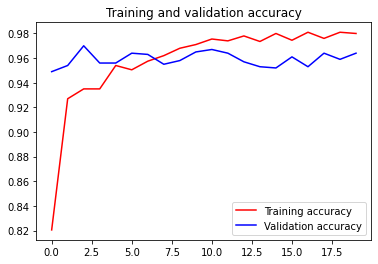

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()